In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from time import time
import os
from skimage.io import imread
import copy
import time
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.models import vgg19
from torchsummary import summary
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
classes = ['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','potted plant','sheep','sofa','train','tv/monitor']
colormap = [[0,0,0],[128,0,0],[0,128,0],[128,128,0],[0,0,128],[128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],[64,128,0],[192,128,0],[64,0,128],[192,0,128],[64,128,128],[192,128,128],[0,64,0],[128,64,0],[0,192,0],[128,192,0],[0,64,128]]

In [19]:
def image2label(image,colormap):
    cm2lbl = np.zeros(256**3)
    print(cm2lbl)
    for i,cm in enumerate(colormap):
        cm2lbl[((cm[0]*256+cm[1])*256+cm[2])] = i
    image = np.array(image,dtype="int64")
    ix = ((image[:,:,0]*256+image[:,:,1]*256+image[:,:,2]))
    image2 = cm2lbl[ix]
    return image2 
cm2lbl = np.zeros(256**3)
print(cm2lbl)

[0. 0. 0. ... 0. 0. 0.]


In [5]:
def rand_crop(data,label,high,width):
    im_width,im_high=data.size
    left=np.random.randint(0,im_width-width)
    top = np.random.randint(0,im_high-high)
    right = left+width
    bottom = top+high
    data = data.crop((left,top,right,bottom))
    label = label.crop((left,top,right,bottom))
    return data,label

In [6]:
def img_transforms(data,label,high,width,colormap):
    data,label = rand_crop(data,label,high,width)
    data_tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225])
    ])
    data = data_tfs(data)
    label = torch.from_numpy(image2label(label,colormap))
    return data,label

In [7]:
def read_image_path(root="D:/archive/VOC2012/ImageSets/Segmentation/train.txt"):
    image = np.loadtxt(root,dtype=str)
    n = len(image)
    data,label = [None]*n , [None]*n
    for i,fname in enumerate(image):
        data[i] = "D:/archive/VOC2012/JPEGImages/%s.jpg"%(fname)
        label[i] = "D:/archive/VOC2012/SegmentationClass/%s.png"%(fname)
    return data,label

In [8]:
class MyDataset(Data.Dataset):
    def __init__(self,data_root,high,width,imtransform,colormap):
        self.data_root = data_root
        self.high = high
        self.width = width
        self.imtransform =imtransform
        self.colormap = colormap
        data_list,label_list = read_image_path(root=data_root)
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
    def _filter(self,images):
        return [im for im in images if (Image.open(im).size[1]>high and Image.open(im).size[0]>width)]
    def __getitem__(self,idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label).convert('RGB')
        img,label = self.imtransform(img,label,self.high,self.width,self.colormap)
        return img,label
    def __len__(self):
        return len(self.data_list)
        

In [9]:
high,width = 320,480
voc_train = MyDataset('D:/archive/VOC2012/ImageSets/Segmentation/train.txt',high,width,img_transforms,colormap)
voc_val = MyDataset('D:/archive/VOC2012/ImageSets/Segmentation/val.txt',high,width,img_transforms,colormap)
train_loader = Data.DataLoader(voc_train,batch_size=4,shuffle=True,num_workers=0,pin_memory=False)
val_loader = Data.DataLoader(voc_val,batch_size=4,shuffle=True,num_workers=0,pin_memory=False)
for step,(b_x,b_y) in enumerate(train_loader):
    if step >0:
        break
print('b_x.shape:',b_x.shape)
print('b_y.shape:',b_y.shape)

b_x.shape: torch.Size([4, 3, 320, 480])
b_y.shape: torch.Size([4, 320, 480])


In [10]:
def inv_normalize_image(data):
    rgb_mean = np.array([0.485,0.456,0.406])
    rgb_std = np.array([0.229,0.224,0.225])
    data = data.astype('float32') * rgb_std + rgb_mean
    return data.clip(0,1)
def label2image(prelabel,colormap):
    h,w = prelabel.shape
    prelabel = prelabel.reshape(h*w,-1)
    image = np.zeros((h*w,3),dtype="int32")
    for ii in range(len(colormap)):
        index = np.where(prelabel ==ii)
        image[index,:] = colormap[ii]
    return image.reshape(h,w,3)


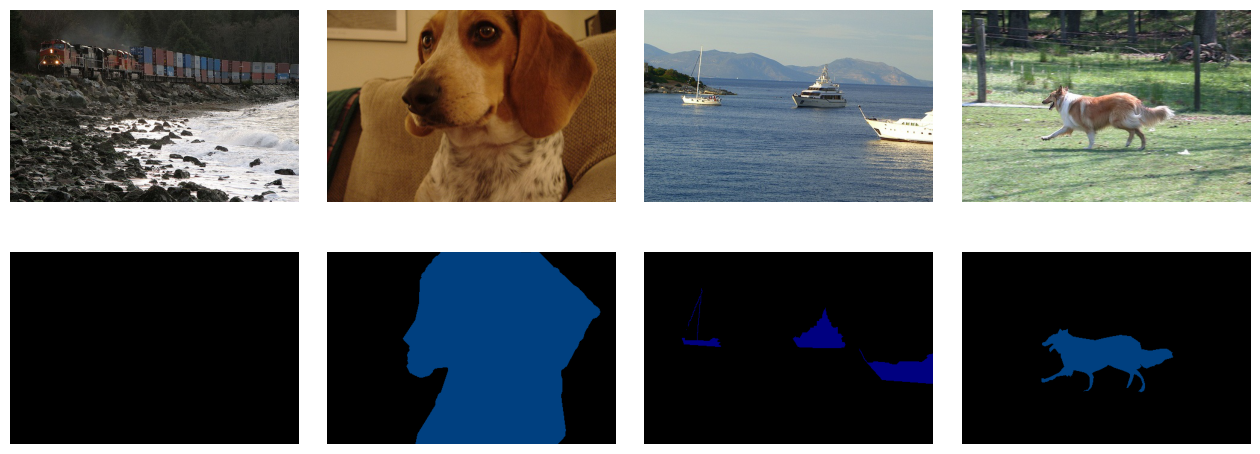

In [11]:
b_x_numpy = b_x.data.numpy()
b_x_numpy = b_x_numpy.transpose(0,2,3,1)
b_y_numpy = b_y.data.numpy()
plt.figure(figsize=(16,6))
for ii in range(4):
    plt.subplot(2,4,ii+1)
    plt.imshow(inv_normalize_image(b_x_numpy[ii]))
    plt.axis("off")
    plt.subplot(2,4,ii+5)
    plt.imshow(label2image(b_y_numpy[ii],colormap))
    plt.axis("off")
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.show()

In [12]:
model_vgg19 = vgg19(pretrained=True)
base_model = model_vgg19.features
base_model = base_model.cuda()
summary(base_model,input_size=(3,high,width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
         MaxPool2d-5         [-1, 64, 160, 240]               0
            Conv2d-6        [-1, 128, 160, 240]          73,856
              ReLU-7        [-1, 128, 160, 240]               0
            Conv2d-8        [-1, 128, 160, 240]         147,584
              ReLU-9        [-1, 128, 160, 240]               0
        MaxPool2d-10         [-1, 128, 80, 120]               0
           Conv2d-11         [-1, 256, 80, 120]         295,168
             ReLU-12         [-1, 256, 80, 120]               0
           Conv2d-13         [-1, 256, 80, 120]         590,080
             ReLU-14         [-1, 256, 

In [13]:
class FCN8s(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.num_classes = num_classes
        model_vgg19 = vgg19(pretrained=True)
        self.base_model = model_vgg19.features
        self.relu = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512,512,kernel_size=3,stride=2,padding=1,dilation=1,output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512,256,3,2,1,1,1)
        self.bn2 = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256,128,3,2,1,1,1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128,64,3,2,1,1,1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64,32,3,2,1,1,1)
        self.bn5 = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32,num_classes,kernel_size=1)
        self.layers = {"4":"maxpool_1","9":"maxpool_2","18":"maxpool_3","27":"maxpool_4","36":"maxpool_5"}
    def forward(self,x):
        output = {}
        for name,layer in self.base_model._modules.items():
            x = layer(x)
            if name in self.layers:
                output[self.layers[name]] = x
        x5 = output["maxpool_5"]
        x4 = output["maxpool_4"]
        x3 = output["maxpool_3"]
        score = self.relu(self.deconv1(x5))
        score = self.bn1(score + x4)
        score = self.relu(self.deconv2(score))
        score = self.bn2(score + x3)
        score = self.bn3(self.relu(self.deconv3(score)))
        score = self.bn4(self.relu(self.deconv4(score)))
        score = self.bn5(self.relu(self.deconv5(score)))
        score = self.classifier(score)
        return score
    

In [14]:
fcn8s = FCN8s(21).to(device)
summary(fcn8s,input_size=(3,high,width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 480]           1,792
              ReLU-2         [-1, 64, 320, 480]               0
            Conv2d-3         [-1, 64, 320, 480]          36,928
              ReLU-4         [-1, 64, 320, 480]               0
         MaxPool2d-5         [-1, 64, 160, 240]               0
            Conv2d-6        [-1, 128, 160, 240]          73,856
              ReLU-7        [-1, 128, 160, 240]               0
            Conv2d-8        [-1, 128, 160, 240]         147,584
              ReLU-9        [-1, 128, 160, 240]               0
        MaxPool2d-10         [-1, 128, 80, 120]               0
           Conv2d-11         [-1, 256, 80, 120]         295,168
             ReLU-12         [-1, 256, 80, 120]               0
           Conv2d-13         [-1, 256, 80, 120]         590,080
             ReLU-14         [-1, 256, 

In [15]:
def train_model(model,criterion,optimizer,traindataloader,valdataloader,num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch{}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        train_loss = 0.0
        train_num = 0
        val_loss = 0.0
        val_num = 0
        model.train()
        for step,(b_x,b_y) in enumerate(traindataloader):
            optimizer.zero_grad()
            b_x = b_x.float().to(device)
            b_y = b_y.long().to(device)
            out = model(b_x)
            out = F.log_softmax(out,dim=1)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out,b_y)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()*len(b_y)
            train_num += len(b_y)
        train_loss_all.append(train_loss/train_num)
        print('{}Train Loss:{:.4f}'.format(epoch,train_loss_all[-1]))
        model.eval()
        for step,(b_x,b_y) in enumerate(valdataloader):
            b_x = b_x.float().to(device)
            b_y = b_y.long().to(device)
            out = model(b_x)
            out = F.log_softmax(out,dim=1)
            pre_lab = torch.argmax(out,1)
            loss = criterion(out,b_y)
            val_loss+=loss.item()*len(b_y)
            val_num+=len(b_y)
        val_loss_all.append(val_loss/val_num)
        print('{}Val Loss:{:.4f}'.format(epoch,val_loss_all[-1]))
        if val_loss_all[-1]<best_loss:
            best_loss = val_loss_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time()-since
        print("Train and Val complete in {:.0f}m {:.0f}s".format(time_use // 60,time_use % 60))
    train_process = pd.DataFrame(data={"epoch":range(num_epochs),"train_loss_all":val_loss_all,"val_loss_all":val_loss_all})
    model.load_state_dict(best_model_wts)
    return model,train_process
            
        


In [16]:
LR = 0.0003
criterion = nn.NLLLoss()
optimizer = optim.Adam(fcn8s.parameters(),lr=LR,weight_decay=1e-4)
fcn8s,train_process = train_model(fcn8s,criterion,optimizer,train_loader,val_loader,num_epochs=30)
torch.save(fcn8s,"fcn8s.pkl")

Epoch0/29
----------
0Train Loss:3.0286


RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 4.00 GiB total capacity; 2.49 GiB already allocated; 0 bytes free; 2.60 GiB reserved in total by PyTorch)